#Understanding the Yolo Algorithm and Fine-Tuning It
____


# Overview of Yolo Algorithm

The YOLO algorithm is designed to preform object detection and image classification. Usually, detection and classification are often two separate models which take two passes, however, yolo combines the two in one pass which is why it's named you only look one. This allows for quick detection and the ability to be used in real time applications.  The following output looks like this:

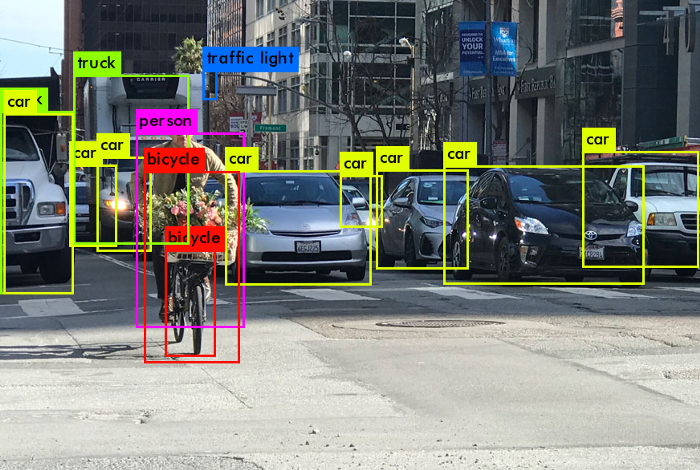

In [1]:
from IPython.display import Image
Image("cover.png")

# Data Engineering

Gage

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
x, t = #TODO.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Model Overview / Example Usage

Ben

# Loss Function

Ben

In [ ]:
import torch
import torch.nn as nn

# CNN Implementation

In [ ]:
class YOLO(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)

    def forward()

Ben

# Training

Gage